# Full LLM Recommender Evaluation with Auto-Save and Advanced Metrics
*Generated on 2025-05-06 09:29 UTC*

Includes:
- Accuracy metrics: Precision, Recall, NDCG, AP@10, RR, Hit@k
- Bias: Log-popularity diff, Long-tail coverage, Average popularity rank
- Fairness metrics: Jaccard@10, PRAG@10, SNSR, SNSV
- Auto-saving plots to `analysisresults/`

In [ ]:

from contextlib import contextmanager
from pathlib import Path
import matplotlib.pyplot as plt

@contextmanager
def autosave_fig(name, folder="analysisresults", dpi=300, fmt="png"):
    path = Path(folder)
    path.mkdir(parents=True, exist_ok=True)
    try:
        yield
        plt.tight_layout()
        plt.savefig(path / f"{name}.{fmt}", dpi=dpi)
    finally:
        plt.show()


In [ ]:

import re

STRATEGY_OPTS = ["random", "top-rated", "recent"]
FAIRNESS_OPTS = ["neutral", "gender_age_only", "occupation_only", "all_attributes"]
BIAS_OPTS = ["baseline", "niche_genre", "exclude_popular", "indie_international", "temporal_diverse", "obscure_theme"]

PROMPT_RE = re.compile(
    r'^(?P<user>\d+)'
    r'_(?P<strategy>' + "|".join(STRATEGY_OPTS) + r')'
    r'_(?P<fairness>' + "|".join(FAIRNESS_OPTS) + r')'
    r'_(?P<bias>' + "|".join(BIAS_OPTS) + r')$'
)

def parse_prompt_id(pid):
    m = PROMPT_RE.match(pid)
    if not m:
        raise ValueError(f"Bad prompt_id: {pid}")
    d = m.groupdict()
    d["user"] = int(d["user"])
    return d


In [ ]:

import pandas as pd, numpy as np, math, collections, itertools
import matplotlib.pyplot as plt, seaborn as sns
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm

USER_DATA_PATH = '../Dataset/full_movies_data.csv'
RECS_PATH      = '../LlmCsvOutput/merged_prompt_results_top_rated.csv'

user_df = pd.read_csv(USER_DATA_PATH)
rec_df = pd.read_csv(RECS_PATH).rename(columns={'custom_id':'prompt_id'})
rec_df['movies'] = rec_df['movies'].str.split(',').apply(lambda lst: [m.strip() for m in lst])
rec_df = pd.concat([rec_df['prompt_id'].apply(parse_prompt_id).apply(pd.Series), rec_df], axis=1)

popularity_counts = user_df['Title'].value_counts()
title_to_rank = {t:r for r, t in enumerate(popularity_counts.index, 1)}
user_likes = user_df[user_df['Rating'] > 2].groupby('UserID')['Title'].apply(set).to_dict()


In [ ]:

def fuzzy_hits(recs, liked, cutoff=80):
    return sum(1 for rec in recs if process.extractOne(rec, liked, scorer=fuzz.token_sort_ratio, score_cutoff=cutoff))

def precision_at_k(recs, liked, k): return fuzzy_hits(recs[:k], liked)/k if k else 0
def recall_at_k(recs, liked, k): return fuzzy_hits(recs[:k], liked)/len(liked) if liked else 0

def ndcg_at_k(recs, liked, k):
    dcg = sum((1 / math.log2(i+2)) for i, itm in enumerate(recs[:k]) if itm in liked)
    ideal = sum(1 / math.log2(i+2) for i in range(min(k, len(liked))))
    return dcg/ideal if ideal else 0

def apk(recs, liked, k):
    score = hits = 0
    for i, itm in enumerate(recs[:k], 1):
        if itm in liked:
            hits += 1
            score += hits/i
    return score / min(len(liked), k) if liked else 0

def rr(recs, liked):
    for i, itm in enumerate(recs, 1):
        if itm in liked: return 1/i
    return 0

def hit_rate_at_k(recs, liked, k):
    top_k = recs[:k]
    return 1 if any(process.extractOne(r, liked, scorer=fuzz.token_sort_ratio, score_cutoff=80) for r in top_k) else 0

def avg_pop_rank(recs): return np.mean([title_to_rank.get(m, len(title_to_rank)+1) for m in recs]) if recs else np.nan

def log_pop_diff(recs, hist):
    rec_pop  = [math.log(popularity_counts.get(m,1)) for m in recs]
    hist_pop = [math.log(popularity_counts.get(m,1)) for m in hist]
    return np.mean(rec_pop) - np.mean(hist_pop) if rec_pop and hist_pop else 0

def is_long_tail(title, cutoff=int(len(title_to_rank)*0.8)):
    return title_to_rank.get(title, cutoff+1) > cutoff

def jaccard_at_k(l1, l2, k):
    A, B = set(l1[:k]), set(l2[:k])
    return len(A & B) / len(A | B) if A | B else 0

def prag_at_k(l1, l2, k):
    r1, r2 = {v:i for i,v in enumerate(l1[:k])}, {v:i for i,v in enumerate(l2[:k])}
    U = set(r1) | set(r2)
    agree = total = 0
    for i,j in itertools.combinations(U,2):
        d1, d2 = r1.get(i,k+1)-r1.get(j,k+1), r2.get(i,k+1)-r2.get(j,k+1)
        if (d1==d2==0) or (d1>0 and d2>0) or (d1<0 and d2<0): agree += 1
        total += 1
    return agree/total if total else 0


In [ ]:

user_hist_cache = {}
records = []

for row in tqdm(rec_df.itertuples(index=False), total=len(rec_df)):
    uid = row.user
    if uid not in user_hist_cache:
        user_hist_cache[uid] = user_df.loc[user_df['UserID'] == uid, 'Title'].tolist()
    hist = user_hist_cache[uid]
    liked = user_likes.get(uid, set())
    movies = row.movies

    records.append({
        "prompt_id": row.prompt_id,
        "user": row.user,
        "strategy": row.strategy,
        "fairness": row.fairness,
        "bias": row.bias,
        "precision@10": precision_at_k(movies, liked, 10),
        "recall@10": recall_at_k(movies, liked, 10),
        "ndcg@10": ndcg_at_k(movies, liked, 10),
        "ap@10": apk(movies, liked, 10),
        "rr": rr(movies, liked),
        "hit_rate@5": hit_rate_at_k(movies, liked, 5),
        "hit_rate@10": hit_rate_at_k(movies, liked, 10),
        "avg_pop_rank": avg_pop_rank(movies),
        "log_pop_diff": log_pop_diff(movies, hist),
        "lt_coverage_pct": sum(is_long_tail(t) for t in movies)/len(movies) if movies else np.nan,
        "jaccard@10": jaccard_at_k(movies, hist, 10),
        "prag@10": prag_at_k(movies, hist, 10),
    })

metrics_df = pd.DataFrame(records)
metrics_df.head()


In [ ]:

# ---- Visualising new metrics ----
bias_order = ["baseline","niche_genre","exclude_popular",
              "indie_international","temporal_diverse","obscure_theme"]

metrics_to_plot = [
    ("hit_rate@5",    "Hit Rate@5"),
    ("hit_rate@10",   "Hit Rate@10"),
    ("jaccard@10",    "Jaccard@10"),
    ("prag@10",       "PRAG@10")
]

for col, label in metrics_to_plot:
    with autosave_fig(f"{col}_by_fairness_lines"):
        plt.figure(figsize=(9,5))
        pivot = (
            metrics_df
            .groupby(['fairness','bias'])[col]
            .mean()
            .unstack('bias')
            .reindex(columns=bias_order)
        )
        for fairness, yvals in pivot.iterrows():
            plt.plot(bias_order, yvals, marker='o', label=fairness)
        plt.title(f"{label} across bias strategies by fairness group")
        plt.xlabel("Bias strategy"); plt.ylabel(label)
        plt.xticks(rotation=45); plt.grid(True, alpha=0.3); plt.legend()


In [ ]:

# --- SNSR and SNSV (group-level fairness dispersion) ---
def snsr(series): return series.max() - series.min() if not series.empty else np.nan
def snsv(series): return series.var() if not series.empty else np.nan

for metric in ["precision@10","hit_rate@10","jaccard@10"]:
    summary = metrics_df.groupby(['fairness','bias'])[metric].mean().unstack('fairness')
    snsr_vals = summary.apply(snsr, axis=1)
    snsv_vals = summary.apply(snsv, axis=1)

    with autosave_fig(f"{metric}_snsr"):
        snsr_vals.plot(kind='bar', title=f"SNSR – {metric}", ylabel='SNSR')
        plt.xticks(rotation=45)

    with autosave_fig(f"{metric}_snsv"):
        snsv_vals.plot(kind='bar', title=f"SNSV – {metric}", ylabel='SNSV')
        plt.xticks(rotation=45)


In [9]:

import re
PROMPT_RE = re.compile(r"""^(?P<user>\d+)_(?P<strategy>random|top-rated|recent)_(?P<fairness>neutral|gender_age_only|occupation_only|all_attributes)_(?P<bias>baseline|niche_genre|exclude_popular|indie_international|temporal_diverse|obscure_theme)$""")

def parse_prompt_id(pid: str):
    m = PROMPT_RE.match(pid)
    if not m:
        raise ValueError(f"Bad prompt_id: {pid}")
    d = m.groupdict()
    d["user"] = int(d["user"])
    return d


In [10]:

# -------- PATHS (edit if needed) --------
USER_DATA_PATH = '../Dataset/full_movies_data.csv'
RECS_PATH      = '../LlmCsvOutput/merged_prompt_results.csv'  # prompt_id,movies

# -------- Imports (inside notebook) --------
import pandas as pd, numpy as np, math, collections, itertools
import matplotlib.pyplot as plt, seaborn as sns
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (8,5)

# -------- Load data --------
user_df = pd.read_csv(USER_DATA_PATH)
rec_df  = pd.read_csv(RECS_PATH).rename(columns={'custom_id':'prompt_id'})  # normalise column

rec_df['movies'] = rec_df['movies'].str.split(',').apply(lambda lst: [m.strip() for m in lst])
rec_df = pd.concat([rec_df['prompt_id'].apply(parse_prompt_id).apply(pd.Series), rec_df], axis=1)

popularity_counts = user_df['Title'].value_counts()
title_to_rank     = {t: r for r, t in enumerate(popularity_counts.index, 1)}
user_likes        = user_df[user_df['Rating'] > 2].groupby('UserID')['Title'].apply(set).to_dict()

print(f"Loaded {len(user_df):,} ratings and {len(rec_df):,} prompt‑lists.")


Loaded 1,000,209 ratings and 139,655 prompt‑lists.


In [ ]:

# -------- Metric helpers --------
def fuzzy_hits(recs, liked, cutoff=65):
    return sum(1 for rec in recs if process.extractOne(rec, liked, scorer=fuzz.token_sort_ratio, score_cutoff=cutoff))

def precision_at_k(recs, liked, k): return fuzzy_hits(recs[:k], liked) / k if k else 0
def recall_at_k(recs, liked, k):    return fuzzy_hits(recs[:k], liked) / len(liked) if liked else 0

def ndcg_at_k(recs, liked, k):
    dcg = sum((1 / math.log2(i+2)) for i, itm in enumerate(recs[:k]) if itm in liked)
    ideal = sum(1 / math.log2(i+2) for i in range(min(k, len(liked))))
    return dcg/ideal if ideal else 0

def apk(recs, liked, k):
    score = hits = 0
    for i, itm in enumerate(recs[:k], 1):
        if itm in liked:
            hits += 1
            score += hits/i
    return score / min(len(liked), k) if liked else 0

def rr(recs, liked):
    for i, itm in enumerate(recs, 1):
        if itm in liked:
            return 1/i
    return 0

def avg_pop_rank(recs):
    return np.mean([title_to_rank.get(m, len(title_to_rank)+1) for m in recs]) if recs else np.nan

def log_pop_diff(recs, hist):
    rec_pop  = [math.log(popularity_counts.get(m,1)) for m in recs]
    hist_pop = [math.log(popularity_counts.get(m,1)) for m in hist]
    return np.mean(rec_pop) - np.mean(hist_pop) if rec_pop and hist_pop else 0

def is_long_tail(title, cutoff=int(len(title_to_rank)*0.8)):
    return title_to_rank.get(title, cutoff+1) > cutoff


In [12]:

user_hist_cache = {}
records = []

for row in tqdm(rec_df.itertuples(index=False), total=len(rec_df), desc="Evaluating"):
    uid = row.user
    if uid not in user_hist_cache:
        user_hist_cache[uid] = user_df.loc[user_df['UserID'] == uid, 'Title'].tolist()
    hist  = user_hist_cache[uid]
    liked = user_likes.get(uid, set())
    movies = row.movies

    records.append({
        "prompt_id"     : row.prompt_id,
        "strategy"      : row.strategy,
        "fairness"      : row.fairness,
        "bias"          : row.bias,
        "precision@10"  : precision_at_k(movies, liked, 10),
        "recall@10"     : recall_at_k(movies, liked, 10),
        "ndcg@10"       : ndcg_at_k(movies, liked, 10),
        "ap@10"         : apk(movies, liked, 10),
        "rr"            : rr(movies, liked),
        "avg_pop_rank"  : avg_pop_rank(movies),
        "log_pop_diff"  : log_pop_diff(movies, hist),
        "lt_coverage_pct": sum(is_long_tail(t) for t in movies)/len(movies) if movies else np.nan
    })

metrics_df = pd.DataFrame(records)
metrics_df.head()


Evaluating:   0%|          | 0/139655 [00:00<?, ?it/s]

,prompt_id,strategy,fairness,bias,precision@10,recall@10,ndcg@10,ap@10,rr,avg_pop_rank,log_pop_diff,lt_coverage_pct
0,1_recent_neutral_baseline,recent,neutral,baseline,0.2,0.037736,0.0,0.0,0.0,3707.0,-6.774215,1.0
1,1_recent_neutral_niche_genre,recent,neutral,niche_genre,0.0,0.000000,0.0,0.0,0.0,3707.0,-6.774215,1.0
2,1_recent_neutral_exclude_popular,recent,neutral,exclude_popular,0.0,0.000000,0.0,0.0,0.0,3707.0,-6.774215,1.0
3,1_recent_neutral_indie_international,recent,neutral,indie_international,0.0,0.000000,0.0,0.0,0.0,3707.0,-6.774215,1.0
4,1_recent_neutral_temporal_diverse,recent,neutral,temporal_diverse,0.1,0.018868,0.0,0.0,0.0,3707.0,-6.774215,1.0


/var/folders/vq/h7xdm9mn3hnc_wv672bpzv8w0000gn/T/ipykernel_27271/3828977355.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=acc_long, x='bias', y='score', hue='metric', ci=None)


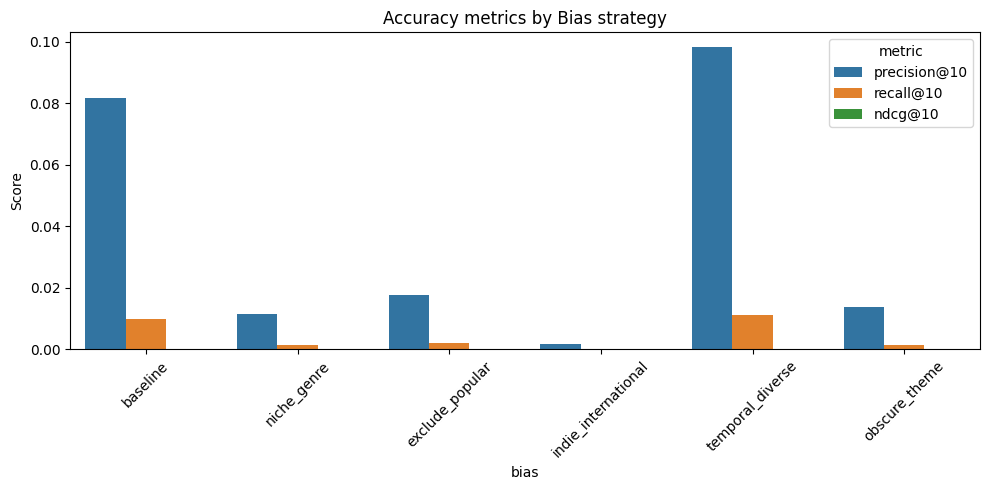

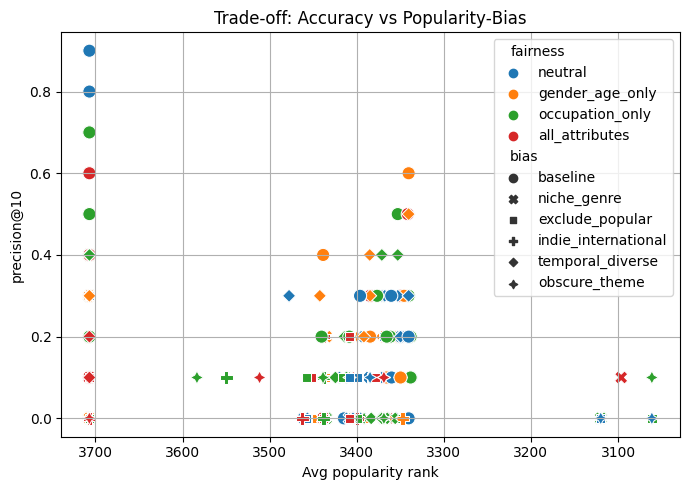

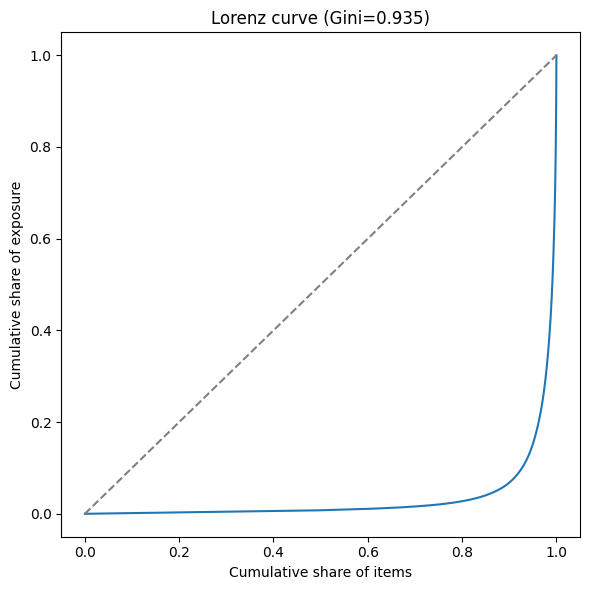

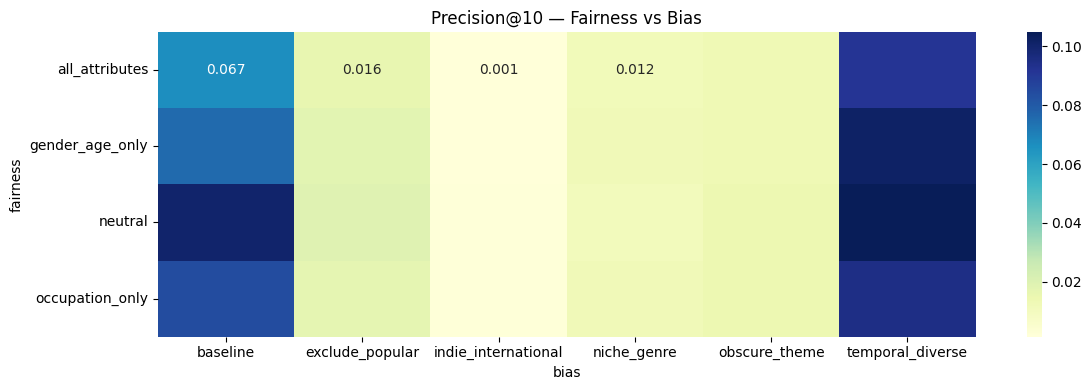

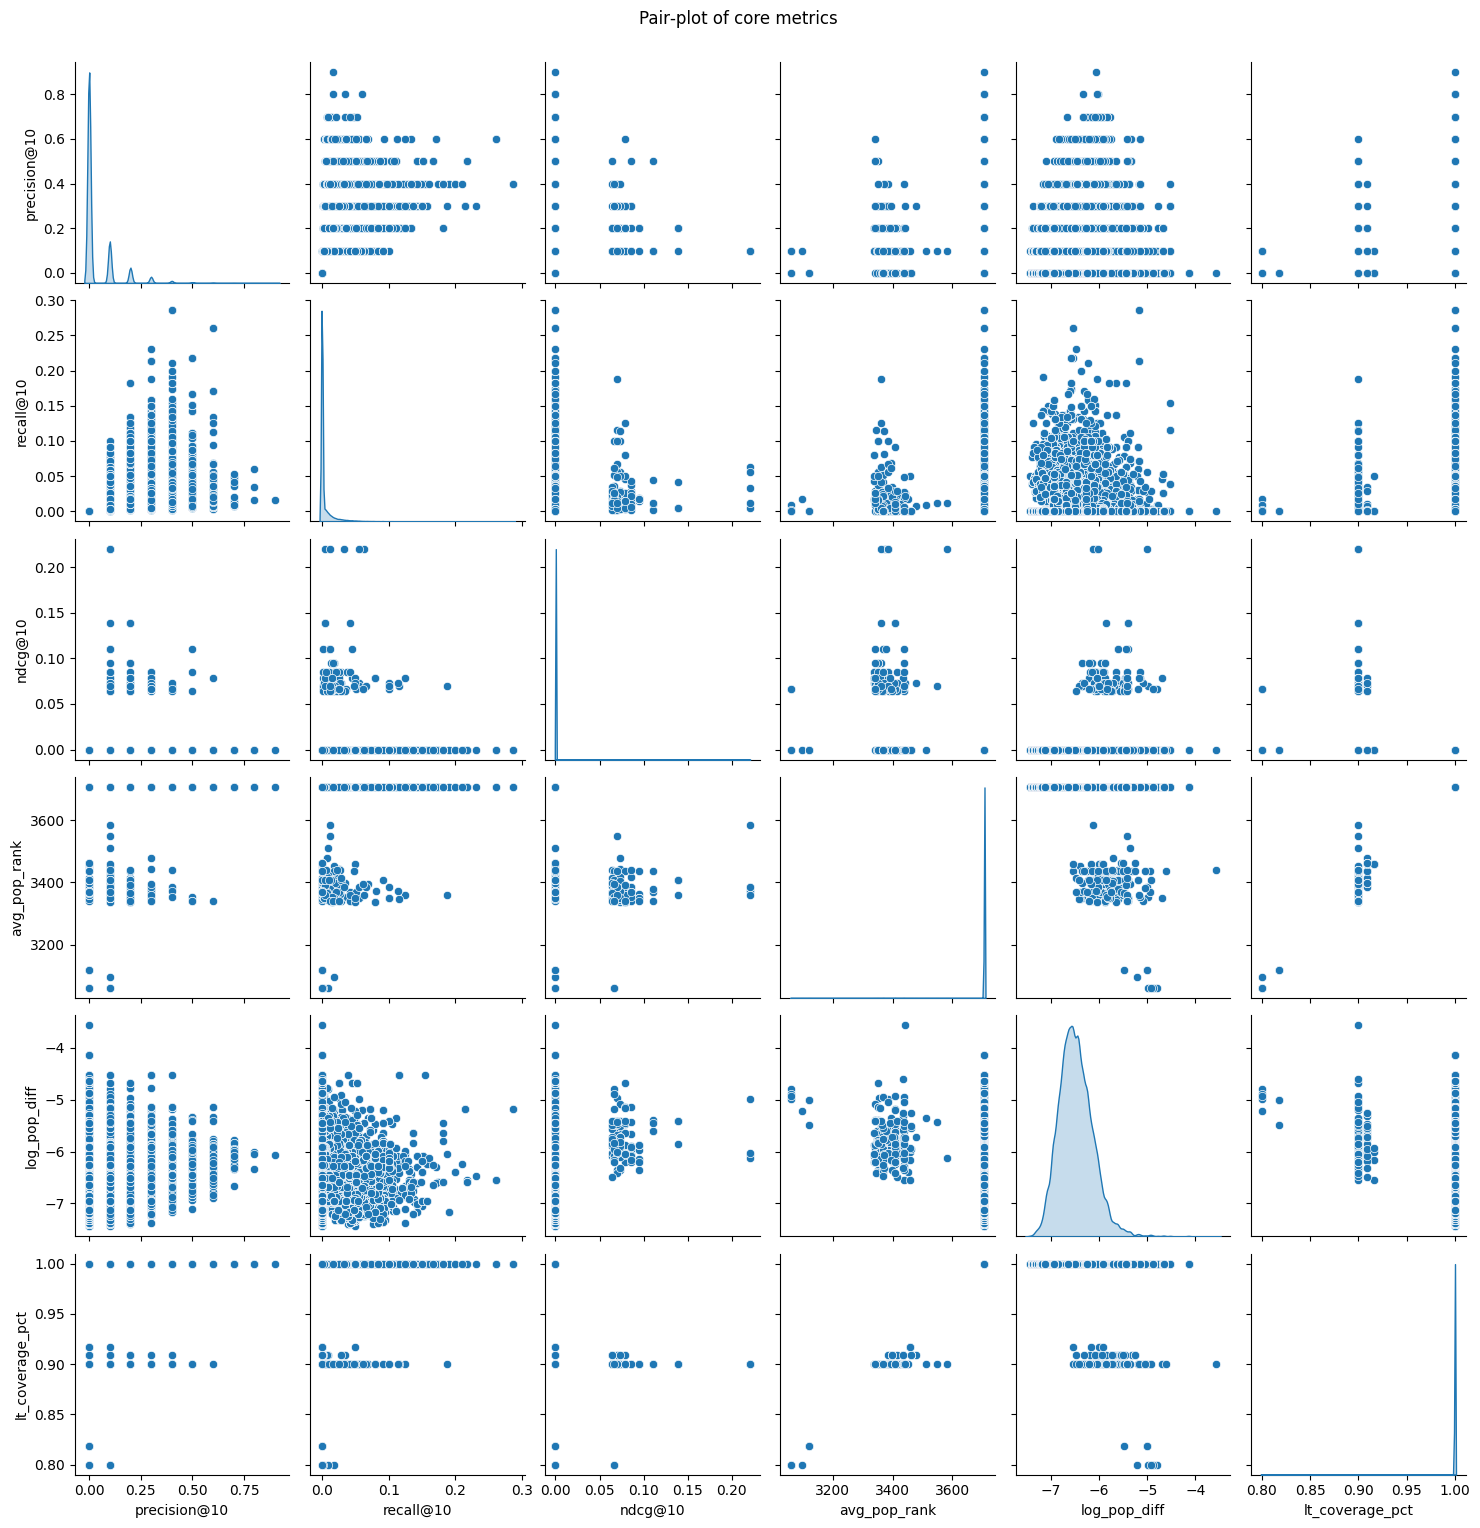

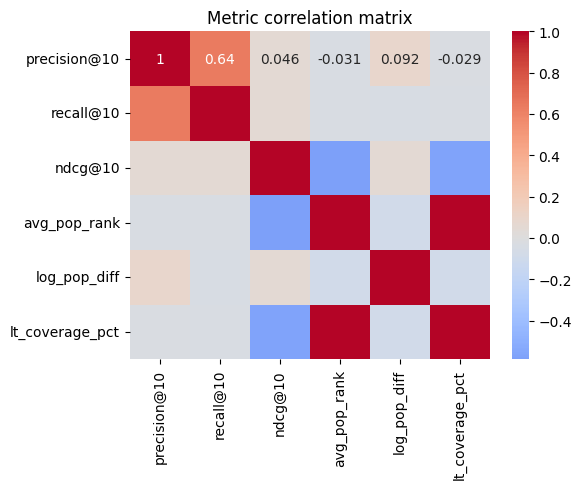

In [13]:

# ========== Visualisations ==========

## 1. Accuracy grouped bar
acc_long = metrics_df.melt(id_vars=['bias','fairness'],
                           value_vars=['precision@10','recall@10','ndcg@10'],
                           var_name='metric', value_name='score')
plt.figure(figsize=(10,5))
sns.barplot(data=acc_long, x='bias', y='score', hue='metric', ci=None)
plt.xticks(rotation=45); plt.ylabel('Score'); plt.title('Accuracy metrics by Bias strategy')
plt.tight_layout(); plt.show()

## 2. Bias–accuracy scatter
plt.figure(figsize=(7,5))
sns.scatterplot(data=metrics_df, x='avg_pop_rank', y='precision@10',
                hue='fairness', style='bias', s=90)
plt.gca().invert_xaxis(); plt.xlabel('Avg popularity rank'); plt.grid(True)
plt.title('Trade‑off: Accuracy vs Popularity‑Bias')
plt.tight_layout(); plt.show()

## 3. Lorenz curve & Gini
from itertools import chain
exposure = collections.Counter(chain.from_iterable(rec_df.movies))
counts = np.array(sorted(exposure.values()))
cum = np.cumsum(counts); lor_x = np.arange(1, len(counts)+1)/len(counts)
lor_y = cum/cum[-1]; gini = 1 - 2*np.trapz(lor_y, lor_x)
plt.figure(figsize=(6,6))
plt.plot(lor_x, lor_y); plt.plot([0,1], [0,1], ls='--', c='gray')
plt.title(f'Lorenz curve (Gini={gini:.3f})')
plt.xlabel('Cumulative share of items'); plt.ylabel('Cumulative share of exposure')
plt.tight_layout(); plt.show()

## 4. Heat‑map Precision by fairness × bias
pivot = metrics_df.groupby(['fairness','bias'])['precision@10'].mean().unstack('bias')
plt.figure(figsize=(12,4))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Precision@10 — Fairness vs Bias'); plt.tight_layout(); plt.show()

## 5. Pair‑plot of core metrics
core = metrics_df[['precision@10','recall@10','ndcg@10',
                   'avg_pop_rank','log_pop_diff','lt_coverage_pct']]
sns.pairplot(core, diag_kind='kde')
plt.suptitle('Pair‑plot of core metrics', y=1.02); plt.show()

## 6. Correlation heat‑map
plt.figure(figsize=(6,5))
sns.heatmap(core.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metric correlation matrix'); plt.tight_layout(); plt.show()


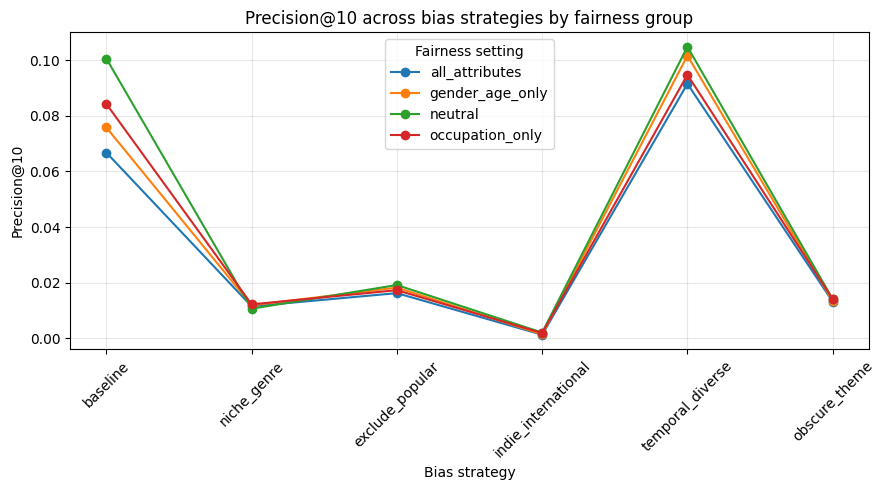

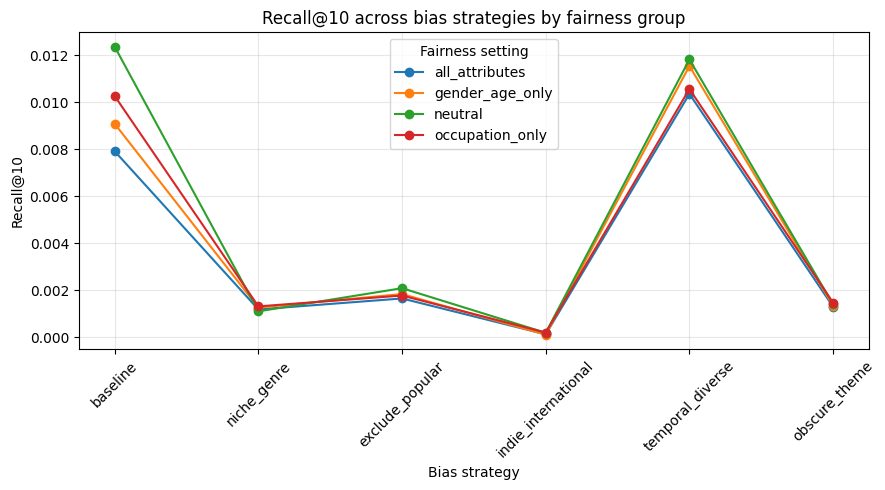

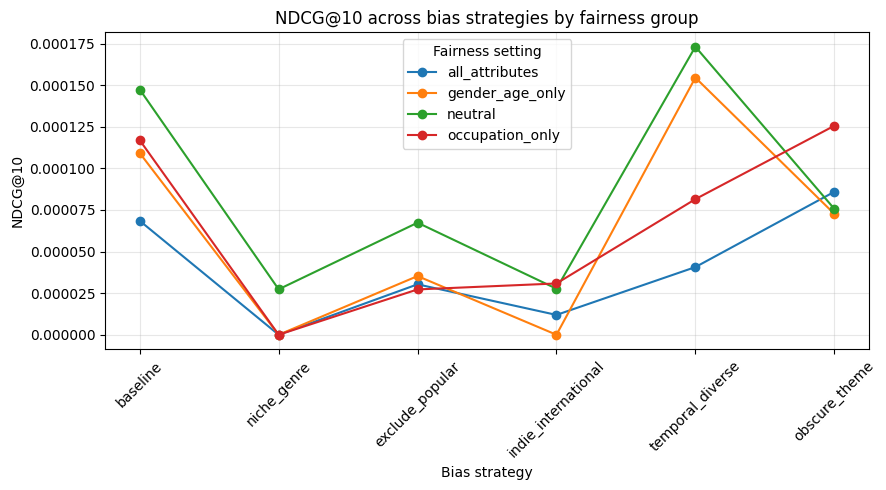

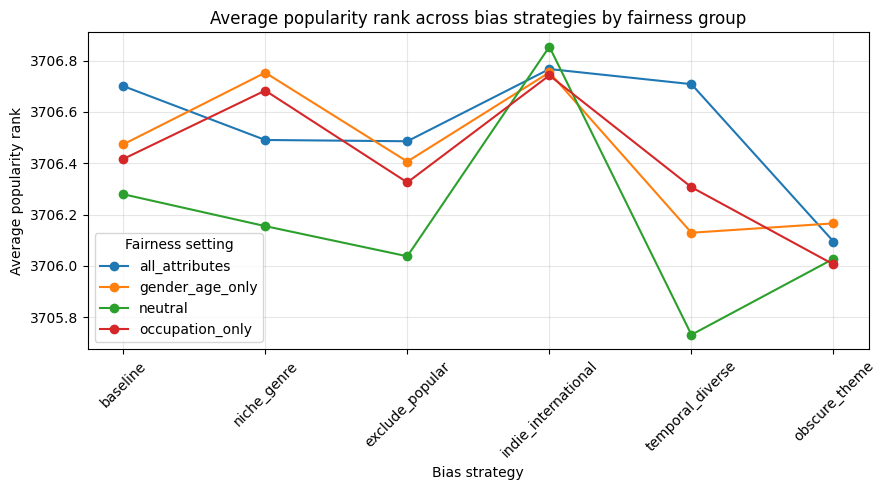

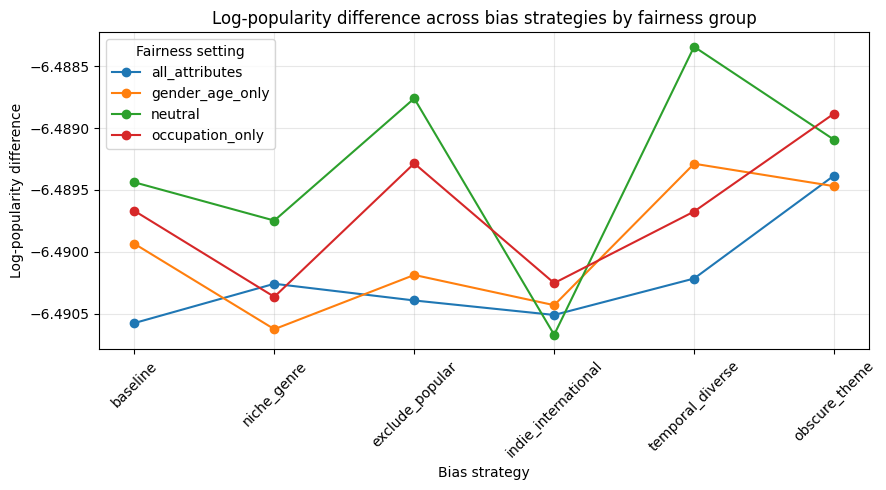

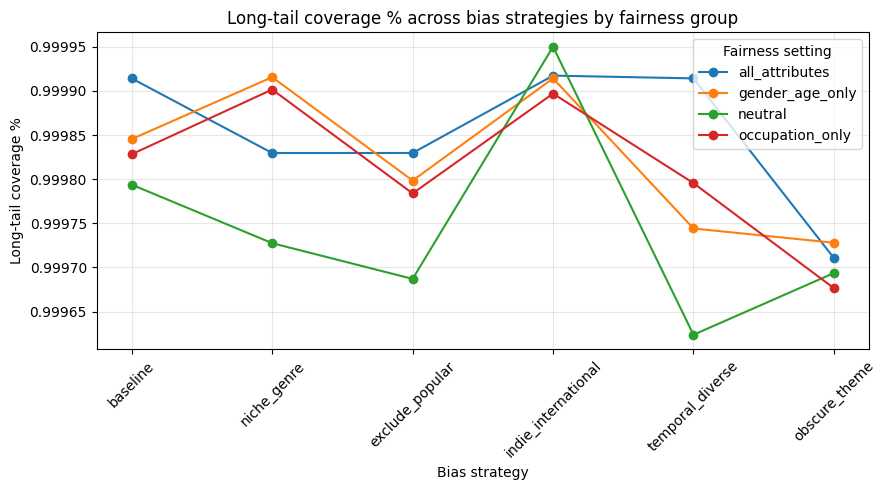

In [14]:
# ── Line-charts: fairness lines over bias strategies ──────────────────────
metrics_to_plot = [
    ("precision@10",      "Precision@10"),
    ("recall@10",         "Recall@10"),
    ("ndcg@10",           "NDCG@10"),
    ("avg_pop_rank",      "Average popularity rank"),
    ("log_pop_diff",      "Log-popularity difference"),
    ("lt_coverage_pct",   "Long-tail coverage %"),
]

# enforce consistent bias order across plots
bias_order = ["baseline","niche_genre","exclude_popular",
              "indie_international","temporal_diverse","obscure_theme"]

for col, label in metrics_to_plot:
    plt.figure(figsize=(9,5))
    
    # pivot: rows=fairness, cols=bias, values=mean(metric)
    pivot = (
        metrics_df
        .groupby(['fairness','bias'])[col]
        .mean()
        .unstack('bias')
        .reindex(columns=bias_order)          # keep logical x-ordering
    )
    
    # one line per fairness value
    for fairness, yvals in pivot.iterrows():
        plt.plot(bias_order, yvals, marker='o', label=fairness)
    
    plt.title(f"{label} across bias strategies by fairness group")
    plt.xlabel("Bias strategy")
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=.3)
    plt.legend(title="Fairness setting")
    plt.tight_layout()
    plt.show()
